# Dataset 2. Classification approach

Here we will try to resolve classification task to say is it fraudlent transaction or not

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split


In [2]:
# load the dataset
df=pd.read_csv("../data/IBM/HI-Small_Trans.csv")

In [3]:
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Timestamp           object 
 1   From Bank           int64  
 2   Account             object 
 3   To Bank             int64  
 4   Account.1           object 
 5   Amount Received     float64
 6   Receiving Currency  object 
 7   Amount Paid         float64
 8   Payment Currency    object 
 9   Payment Format      object 
 10  Is Laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 426.2+ MB


In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df.shape

(5078336, 11)

# Data Distribution

In [7]:
df["Is Laundering"].value_counts()

Is Laundering
0    5073159
1       5177
Name: count, dtype: int64

In [8]:
df["Is Laundering"].value_counts(normalize=True)*100

Is Laundering
0    99.898057
1     0.101943
Name: proportion, dtype: float64

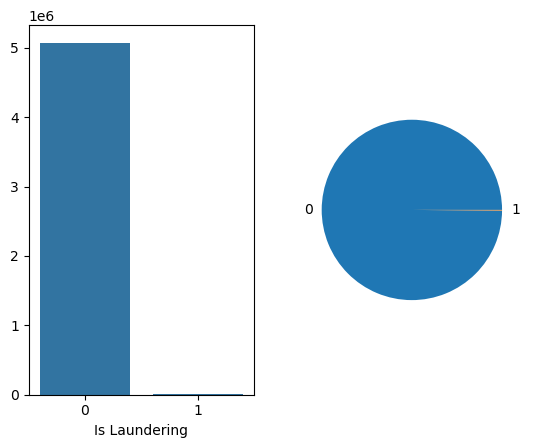

In [9]:
target_count=df["Is Laundering"].value_counts()
plt.subplot(1,2,1)
sns.barplot(x=target_count.index,y=target_count.values)
plt.subplot(1,2,2)
plt.pie(target_count.values,labels=target_count.index);

# Feature preparation

In [10]:
# Convert the "Timestamp" column to datetime format
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# Extract Date, Day, and Time from the Timestamp
df["Date"] = df["Timestamp"].dt.date
df["Day"] = df["Timestamp"].dt.day_name()
df["Time"] = df["Timestamp"].dt.time                                              

df.drop(columns=["Timestamp"], inplace=True)

In [11]:
df.head(2)

,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Date,Day,Time
0,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0,2022-09-01,Thursday,00:20:00
1,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0,2022-09-01,Thursday,00:20:00


In [12]:
# Define the X and Y
 
X = df.drop(['Is Laundering'],axis = 1)
y = df['Is Laundering']

# Oversampling for dealing with small fraudlent-class

In [13]:
X = df.drop(['Is Laundering'],axis = 1)
y = df['Is Laundering']

oversampler = RandomOverSampler(sampling_strategy=0.5) # Increase the minority class to 50% of the majority class
X, y = oversampler.fit_resample(X, y)

len(X),len(y)

(7609738, 7609738)

In [14]:
# # Undersampling is possible too but less effective according to our tests
# # Define the undersampler

# undersampler = RandomUnderSampler()
# X, y = undersampler.fit_resample(X,y)
# len(X),len(y)

# Visualizing The balanced Dataset

<Axes: xlabel='Is Laundering'>

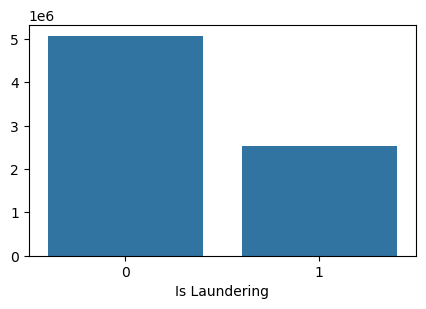

In [15]:
new_distribution=y.value_counts()
plt.figure(figsize=(5,3))
sns.barplot(x=new_distribution.index,y=new_distribution.values)

# Train and test split 

In [16]:

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [17]:
y_train.value_counts()

Is Laundering
0    3551670
1    1775146
Name: count, dtype: int64

In [18]:
y_test.value_counts()

Is Laundering
0    1521489
1     761433
Name: count, dtype: int64

# One hot encoding inside a pipeline together with model

In [19]:
categorical = ['From Bank','Account','To Bank','Receiving Currency','Payment Currency','Payment Format','Day']

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
ohe = Pipeline([('Encoder',OneHotEncoder(drop = 'first',handle_unknown='ignore'))])

In [21]:
from sklearn.compose import ColumnTransformer
transformer = ColumnTransformer([('One Hot Encoding',ohe,categorical)])

In [22]:
from xgboost import XGBClassifier
# Define the full pipeline without the undersampler
model = Pipeline([
    ('Transformer', transformer),           # Preprocess the data
    ('Estimator', XGBClassifier())          # Train the model with XGBoost
])

In [23]:
type(model[0])

sklearn.compose._column_transformer.ColumnTransformer

# Fitting the model

In [24]:
model.fit(X_train, y_train)

%%time

Pipeline(steps=[('Transformer',
                 ColumnTransformer(transformers=[('One Hot Encoding',
                                                  Pipeline(steps=[('Encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['From Bank', 'Account',
                                                   'To Bank',
                                                   'Receiving Currency',
                                                   'Payment Currency',
                                                   'Payment Format',
                                                   'Day'])])),
                ('Estimator',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=No...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [25]:
type(model[0])

sklearn.compose._column_transformer.ColumnTransformer

In [26]:
feature_names = model[0].get_feature_names_out()

In [27]:
feature_names

array(['One Hot Encoding__From Bank_3', 'One Hot Encoding__From Bank_4',
       'One Hot Encoding__From Bank_5', ...,
       'One Hot Encoding__Day_Thursday', 'One Hot Encoding__Day_Tuesday',
       'One Hot Encoding__Day_Wednesday'], dtype=object)

In [28]:
len(feature_names) # Total number of features after one-hot encoding

# It's all possible combinations of the categorical variables converted to numerical values

478877

# Feature importance

After fitting the model we can estimate which features was the most and the less important to find the class of transaction during the fitting

In [29]:
# feature_names = transformer.get_feature_names_out()
feature_names = model[0].get_feature_names_out()
importances = model[1].feature_importances_

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feat_imp_df.head(20)  # The most important features

# As expected, "From Bank 70" is in the top 10 features, but it is not the most important one.
# The most important feature in general is "Payment Format": it's first 5 rows

,Feature,Importance
478869,One Hot Encoding__Payment Format_Reinvestment,0.101950
478870,One Hot Encoding__Payment Format_Wire,0.052319
478868,One Hot Encoding__Payment Format_Credit Card,0.033830
478837,One Hot Encoding__Receiving Currency_Bitcoin,0.032410
478866,One Hot Encoding__Payment Format_Cash,0.023262
478867,One Hot Encoding__Payment Format_Cheque,0.016060
23,One Hot Encoding__From Bank_70,0.011363
478858,One Hot Encoding__Payment Currency_Saudi Riyal,0.010640
478862,One Hot Encoding__Payment Currency_US Dollar,0.009583
478859,One Hot Encoding__Payment Currency_Shekel,0.007091


In [30]:
feat_imp_df.Importance.sum() # total sum of importances == 1.0 


1.0000001

In [31]:
feat_imp_df.head(2)

,Feature,Importance
478869,One Hot Encoding__Payment Format_Reinvestment,0.101950
478870,One Hot Encoding__Payment Format_Wire,0.052319


In [32]:
feat_imp_df["Importance"].head(50).sum()  

# The top-10 most important features gives us 42% of the whole importance
# So, given firt 10 features, we can be 42% sure that the model will be able to predict fraudlent transaction

0.43548867

In [33]:
feat_imp_df.tail(20) # The less important features

# In the end of the list we have Feature named after some Accounts numbers. 
# So in general it could be interpreted as list of trusted accounts who has never been seen laundering before

,Feature,Importance
159980,One Hot Encoding__Account_805DDD7E0,0.0
159979,One Hot Encoding__Account_805DDD6A0,0.0
159978,One Hot Encoding__Account_805DDD220,0.0
159977,One Hot Encoding__Account_805DDCFD0,0.0
159976,One Hot Encoding__Account_805DDCD10,0.0
159975,One Hot Encoding__Account_805DDCBD0,0.0
159974,One Hot Encoding__Account_805DDC9B0,0.0
159973,One Hot Encoding__Account_805DDC8C0,0.0
159972,One Hot Encoding__Account_805DDC870,0.0
159971,One Hot Encoding__Account_805DDC0B0,0.0


# Inference

In [34]:
y_pred = model.predict(X_test)

%time

c:\Users\HAL9003\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


CPU times: total: 0 ns
Wall time: 0 ns


In [35]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [36]:
y_pred.mean()

0.36861574771279965

In [37]:
y_test.value_counts()
# Feature Scaling

Is Laundering
0    1521489
1     761433
Name: count, dtype: int64

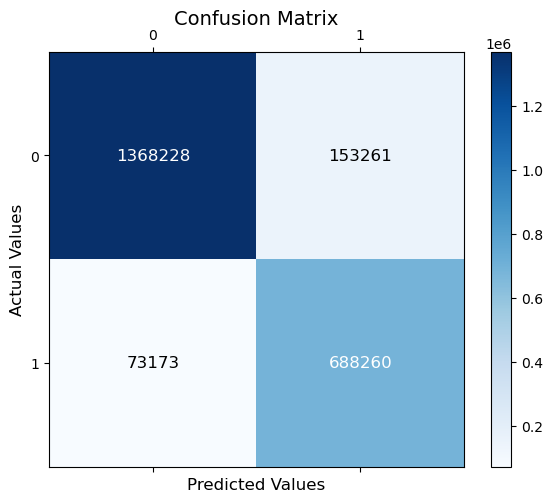

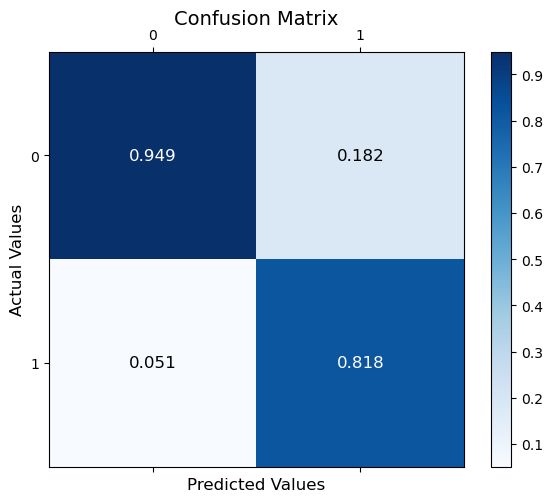

In [38]:
def draw_confusion_matrix(cm):
    fig, ax = plt.subplots(figsize=(6, 5))
    cax = ax.matshow(cm, cmap='Blues')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]),
                    va='center', ha='center',
                    color='black' if cm[i, j] < cm.max() * 0.5 else 'white',
                    fontsize=12)

    ax.set_xlabel('Predicted Values', fontsize=12)
    ax.set_ylabel('Actual Values', fontsize=12)
    ax.set_title('Confusion Matrix', fontsize=14, pad=20)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    fig.colorbar(cax)
    plt.tight_layout()
    plt.show()

# Draw the confusion matrix using the function
draw_confusion_matrix(cm = confusion_matrix(y_test, y_pred, normalize=None))

# Normalized confusion matrix
draw_confusion_matrix(cm = confusion_matrix(y_test, y_pred, normalize='pred').round(3))

In [39]:
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92   1521489
           1       0.82      0.90      0.86    761433

    accuracy                           0.90   2282922
   macro avg       0.88      0.90      0.89   2282922
weighted avg       0.91      0.90      0.90   2282922



In [40]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print("Accuracy Score:", accuracy_score(y_test, y_pred)*100)
print("Precision Score:",precision_score(y_test, y_pred)*100)
print("Recall Score:",recall_score(y_test, y_pred)*100)
print("F1 Score:", f1_score(y_test, y_pred)*100)


Accuracy Score: 90.0813956850037
Precision Score: 81.78762027329086
Recall Score: 90.390093415967
F1 Score: 85.87395521019319


# Tests with non-oversampled example 

In [41]:
# Get the original data without the oversampling


X_orig = df.drop(['Is Laundering'],axis = 1)
y_orig = df['Is Laundering']

In [42]:
y_orig_predict = model.predict(X_orig) 

# ecoding the original data using the same transformer in model[0]
# then predict using previously trained model

# Get some warnings about the data here because we have not used all the features in the model during the training

c:\Users\HAL9003\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [43]:
print("Accuracy Score:", accuracy_score(y_orig, y_orig_predict)*100)
print("Precision Score:",precision_score(y_orig, y_orig_predict)*100)
print("Recall Score:",recall_score(y_orig, y_orig_predict)*100)
print("F1 Score:", f1_score(y_orig, y_orig_predict)*100)


# Our precision here drops to 60% because amout of fraudlent transactions is much lower 
#       than in the training set,
#       so in 'real life' sample the model tend to show 'false positive' much more often.

# But it's still acceptable for the model to be used in production, because usually 
#       we prefer to stop potentially fraudlent transaction
#       and then check it manually, rather than let it go through and then find out 
#       that it was a fraudlent one.

Accuracy Score: 89.98518412330338
Precision Score: 0.912308757422991
Recall Score: 90.36121305775545
F1 Score: 1.806379864926961


In [44]:
y_orig_predict.mean()

0.10097106611299449

In [45]:
y_orig.mean() # below 1% of fraudlent transactions 

0.0010194284111961084

In [46]:
y_orig.sum() 

# Just to remember -- in the original data we have 5177 of fraudlent transactions

5177

In [47]:
# Being implemented in production, the model could be a little bit too agressive selecting fraudlent transactions
#   we should be careful with the thresholds and model parameters to avoid too many false positives
#   to prevent too many customers from being blocked and too many transactions 
#   from being stopped for manual check, for example

y_orig_predict.sum() # And we have much more predicted fraudlent transactions 

512765

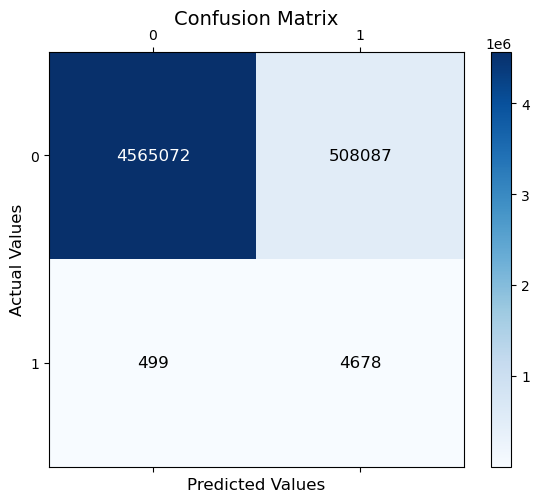

In [48]:
# Normalized confusion matrix for the original data
draw_confusion_matrix(cm = confusion_matrix(y_orig, y_orig_predict, normalize=None).round(3))


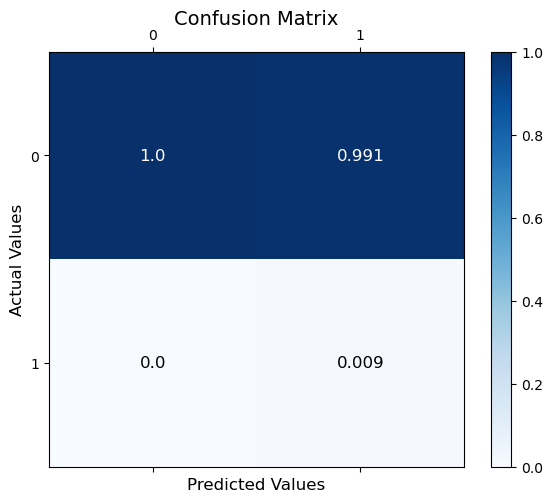

In [49]:
# Normalized confusion matrix for the original data
draw_confusion_matrix(cm = confusion_matrix(y_orig, y_orig_predict, normalize='pred').round(3))

# False positive is huge, because we have much more predicted fraudlent transactions than in the original data
# So we have just created too biased model, which says 'it's fraudlent' probably too often